In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, r2_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC


from os.path import isfile

import pickle

import time

import matplotlib.pyplot as plt

import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance

import warnings

In [2]:
def train_decision_tree(file_name: str, X_train: pd.DataFrame, y_train: pd.DataFrame):
    file_path = './data/models/' + file_name + '.pkl'
    train_model = DecisionTreeClassifier(random_state=42)
    
    if isfile(file_path):
        with open(file_path, 'rb') as m_file:
            train_model = pickle.load(m_file)
    else:
        start_time = time.time()
        
        result = None
    
        params = [
            {
                'criterion': ['gini', 'entropy'], 
                'splitter': ['best', 'random'], 
                'max_depth': np.concatenate(np.arange(1, 15, 1), None),
                'min_samples_split': np.arange(2, 4, 1), 
                'min_samples_leaf': np.arange(1, 3, 1), 
                'min_weight_fraction_leaf': np.arange(0.0, 0.3, 0.1), 
                'max_features': ['auto', 'sqrt', 'log2', None], 
                'max_leaf_nodes': np.concatenate(np.arange(2, 3, 1), None),
                'min_samples_split': np.arange(2, 5, 1), 
                'min_impurity_decrease': np.arange(0.0, 0.3, 0.1), 
                'class_weight': ['balanced', None],
                #'ccp_alpha': np.arange(0.0, .01, 0.0001)
            }
        ]
    
        cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
        grid_search = GridSearchCV(estimator=train_model, param_grid=params, cv=cross_val, n_jobs=-1, scoring='roc_auc', error_score='raise', verbose=1)
    
        result = grid_search.fit(X_train, y_train)
    
        train_model = result.best_estimator_
    
        print(result.best_params_)
        print("Training took {:.2f}s.".format((time.time() - start_time)))
        
        with open(file_path, 'wb') as m_file:
            pickle.dump(train_model, m_file)
            
    return train_model

In [3]:
def train_random_forest(file_name: str, X_train: pd.DataFrame, y_train: pd.DataFrame):
    file_path = './data/models/' + file_name + '.pkl'
    train_model = RandomForestClassifier(random_state=42)
    
    if isfile(file_path):
        with open(file_path, 'rb') as m_file:
            train_model = pickle.load(m_file)
    else:
        start_time = time.time()
        
        result = None
    
        params = [
            {
                'n_estimators': np.arange(50, 150, 50),
                'criterion': ['gini', 'entropy'], 
                'max_depth': np.concatenate(np.arange(1, 15, 1), None),
                #'min_samples_split': np.arange(2, 4, 1), 
                #'min_samples_leaf': np.arange(1, 3, 1), 
                #'min_weight_fraction_leaf': np.arange(0.0, 0.3, 0.1), 
                'max_features': ['auto', 'sqrt', 'log2', None], 
                'max_leaf_nodes': np.concatenate(np.arange(2, 3, 1), None),
                'min_samples_split': np.arange(2, 5, 1), 
                #'min_impurity_decrease': np.arange(0.0, 0.3, 0.1), 
                'class_weight': ['balanced', None],
                #'ccp_alpha': np.arange(0.0, .01, 0.001)
            }
        ]
    
        cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
        grid_search = GridSearchCV(estimator=train_model, param_grid=params, cv=cross_val, n_jobs=-1, scoring='roc_auc', error_score='raise', verbose=1)
    
        result = grid_search.fit(X_train, y_train)
    
        train_model = result.best_estimator_
    
        print(result.best_params_)
        print("Training took {:.2f}s.".format((time.time() - start_time)))
        
        with open(file_path, 'wb') as m_file:
            pickle.dump(train_model, m_file)
            
    return train_model

In [4]:
def plot_roc(predict_proba: np.array, test: np.array, name: str, n_class: int, colors: list, labels: list, fig_size: tuple):
    fp, tp, thr = {}, {}, {}
    
    f, ax = plt.subplots(1, figsize=fig_size)
    plt.title(name)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for i in range(n_class):
        fp[i], tp[i], thr[i] = roc_curve(test, predict_proba[:,i], pos_label=i)
        plt.plot(fp[i], tp[i], linestyle='--',color=colors[i], label=labels[i])
    
    plt.show()

In [5]:
preg = lambda x: np.NaN if np.isnan(x) else 0 if x  >= 0 and x < 3 else 1 if x >= 3 and x < 7 else 2
glucose = lambda x: np.NaN if np.isnan(x) else 0 if x >= 0 and x < 89.2 else 1 if x >= 89.2 and x < 107.2 else 2 if x >= 107.2 and x < 123.2 else 3 if x >= 123.2 and x < 143.2 else 4 if x >= 143.2 and x < 155.2 else 5
blood_p = lambda x: np.NaN if np.isnan(x) else 0 if x >= 0 and x < 76.2 else 1 if x >= 76.2 and x < 98.2 else 2 
skin_t = lambda x: np.NaN if np.isnan(x) else 0 if x >= 0 and x < 26 else 1 if x >= 26 and x < 33 else 2
insulin = lambda x: np.NaN if np.isnan(x) else 0 if x >= 0 and x < 111 else 1 if x >= 111 and x < 151 else 2 if x >= 151 and x < 241 else 3 
bmi = lambda x: np.NaN if np.isnan(x) else 0 if x >= 0 and x < 22.815 else 1 if x >= 22.815 and x < 26.841 else 2 if x >= 26.841 and x < 33.551 else 3 if x >= 33.551 and x < 35.563 else 4 
dpf = lambda x: np.NaN if np.isnan(x) else 0 if x >= 0 and x< .245 else 1 if x >= .245 and x < .526 else 2 if x >= .526 and x < .806 else 3 if x >= .806 and x < 1.111 else 4
age = lambda x: np.NaN if np.isnan(x) else 0 if x >= 21 and x < 25 else 1 if x >= 25 and x < 31 else 2 if x >= 31 and x < 41 else 3 if x >= 41 and x < 56 else 4


def construct_df(in_df: pd.DataFrame, in_columns: list):
    result_df = pd.DataFrame(columns=in_columns)
    
    result_df['Pregnancies'] = in_df['Pregnancies'].map(preg)
    result_df['Glucose'] = in_df['Glucose'].map(glucose)
    result_df['BloodPressure'] = in_df['BloodPressure'].map(blood_p)
    result_df['SkinThickness'] = in_df['SkinThickness'].map(skin_t)
    result_df['Insulin'] = in_df['Insulin'].map(insulin)
    result_df['BMI'] = in_df['BMI'].map(bmi)
    result_df['DiabetesPedigreeFunction'] = in_df['DiabetesPedigreeFunction'].map(dpf)
    result_df['Age'] = in_df['Age'].map(age)
    
    return result_df
    

In [6]:
colors = {
    0: 'orange',
    1: 'green',
}

labels = {
    0: 'Healthy',
    1: 'Sick'
}

## **Источник данных.**

Насколько я понял, изначально датасет был собран в рамках исследования <a href="https://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC2245318&blobtype=pdf">"Using the ADAP Learning Algorithm to Forecastthe Onset of Diabetes Mellitus"</a>

По крайней мере, я не нашел формулы и описания DiabetesPedigreeFunction больше нигде.

Полезно знать, что <a href="https://ru.wikipedia.org/wiki/%D0%9F%D0%B8%D0%BC%D0%B0">индейцы племеи Пима</a> имеют ненормально высокий уровень заболеваемости диабетом второго типа.

## **Импорт данных.**

In [7]:
src_df = pd.read_csv(filepath_or_buffer='./data/pima-indians-diabetes.csv')

In [8]:
src_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Class                       0
dtype: int64

In [9]:
src_df.shape

(768, 9)

In [10]:
src_df.drop_duplicates(inplace=True)

In [11]:
src_df.shape

(768, 9)

In [12]:
src_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Выглядит всё неплохо. Дубликатов нет, отсутствующих значений нет. Но меня удивляют нулевые значения в Glucose, BloodPressure, SkinThikness, Insulin и BMI.

Придется их заменить на NaN, поскольку нулевых значений там не может быть по определению.

In [13]:
src_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = src_df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

In [14]:
src_df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Class                         0
dtype: int64

Да, неприятно.

Теперь нужно разбираться с семантикой параметров. Очевидные пропущу.

BMI - <a href="https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_%D0%BC%D0%B0%D1%81%D1%81%D1%8B_%D1%82%D0%B5%D0%BB%D0%B0">Индекс массы тела.</a>

Diabetes pedigree function - наследственная склонность к диабету. Это синтетическая функция. Описана в оригинальном исследовании.

## **Экспериментальная модель.**

Для начала попробую выбросить все отсутствующие значения и построить на базе этого датасета модель для оценки значимости предикторов.

In [15]:
exp_df = src_df.dropna(axis=0)

In [16]:
exp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,392.0,3.301020,3.211424,0.000,1.00000,2.0000,5.000,17.00
Glucose,392.0,122.627551,30.860781,56.000,99.00000,119.0000,143.000,198.00
BloodPressure,392.0,70.663265,12.496092,24.000,62.00000,70.0000,78.000,110.00
SkinThickness,392.0,29.145408,10.516424,7.000,21.00000,29.0000,37.000,63.00
Insulin,392.0,156.056122,118.841690,14.000,76.75000,125.5000,190.000,846.00
BMI,392.0,33.086224,7.027659,18.200,28.40000,33.2000,37.100,67.10
DiabetesPedigreeFunction,392.0,0.523046,0.345488,0.085,0.26975,0.4495,0.687,2.42
Age,392.0,30.864796,10.200777,21.000,23.00000,27.0000,36.000,81.00
Class,392.0,0.331633,0.471401,0.000,0.00000,0.0000,1.000,1.00


In [17]:
print("Classes balance:\nNo diabete:\t\t{} ({:.2f}%)\nDiabete present:\t{} ({:.2f}%)".format(
    exp_df['Class'].isin([0]).sum(), exp_df['Class'].isin([0]).sum()/(exp_df.shape[0]/100),
    exp_df['Class'].isin([1]).sum(), exp_df['Class'].isin([1]).sum()/(exp_df.shape[0]/100)
))

Classes balance:
No diabete:		262 (66.84%)
Diabete present:	130 (33.16%)


Не идеально, но работать можно.

In [18]:
X_e = exp_df.drop('Class', axis=1)
y_e = exp_df[['Class']]

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, shuffle=True, random_state=42, stratify=y_e)

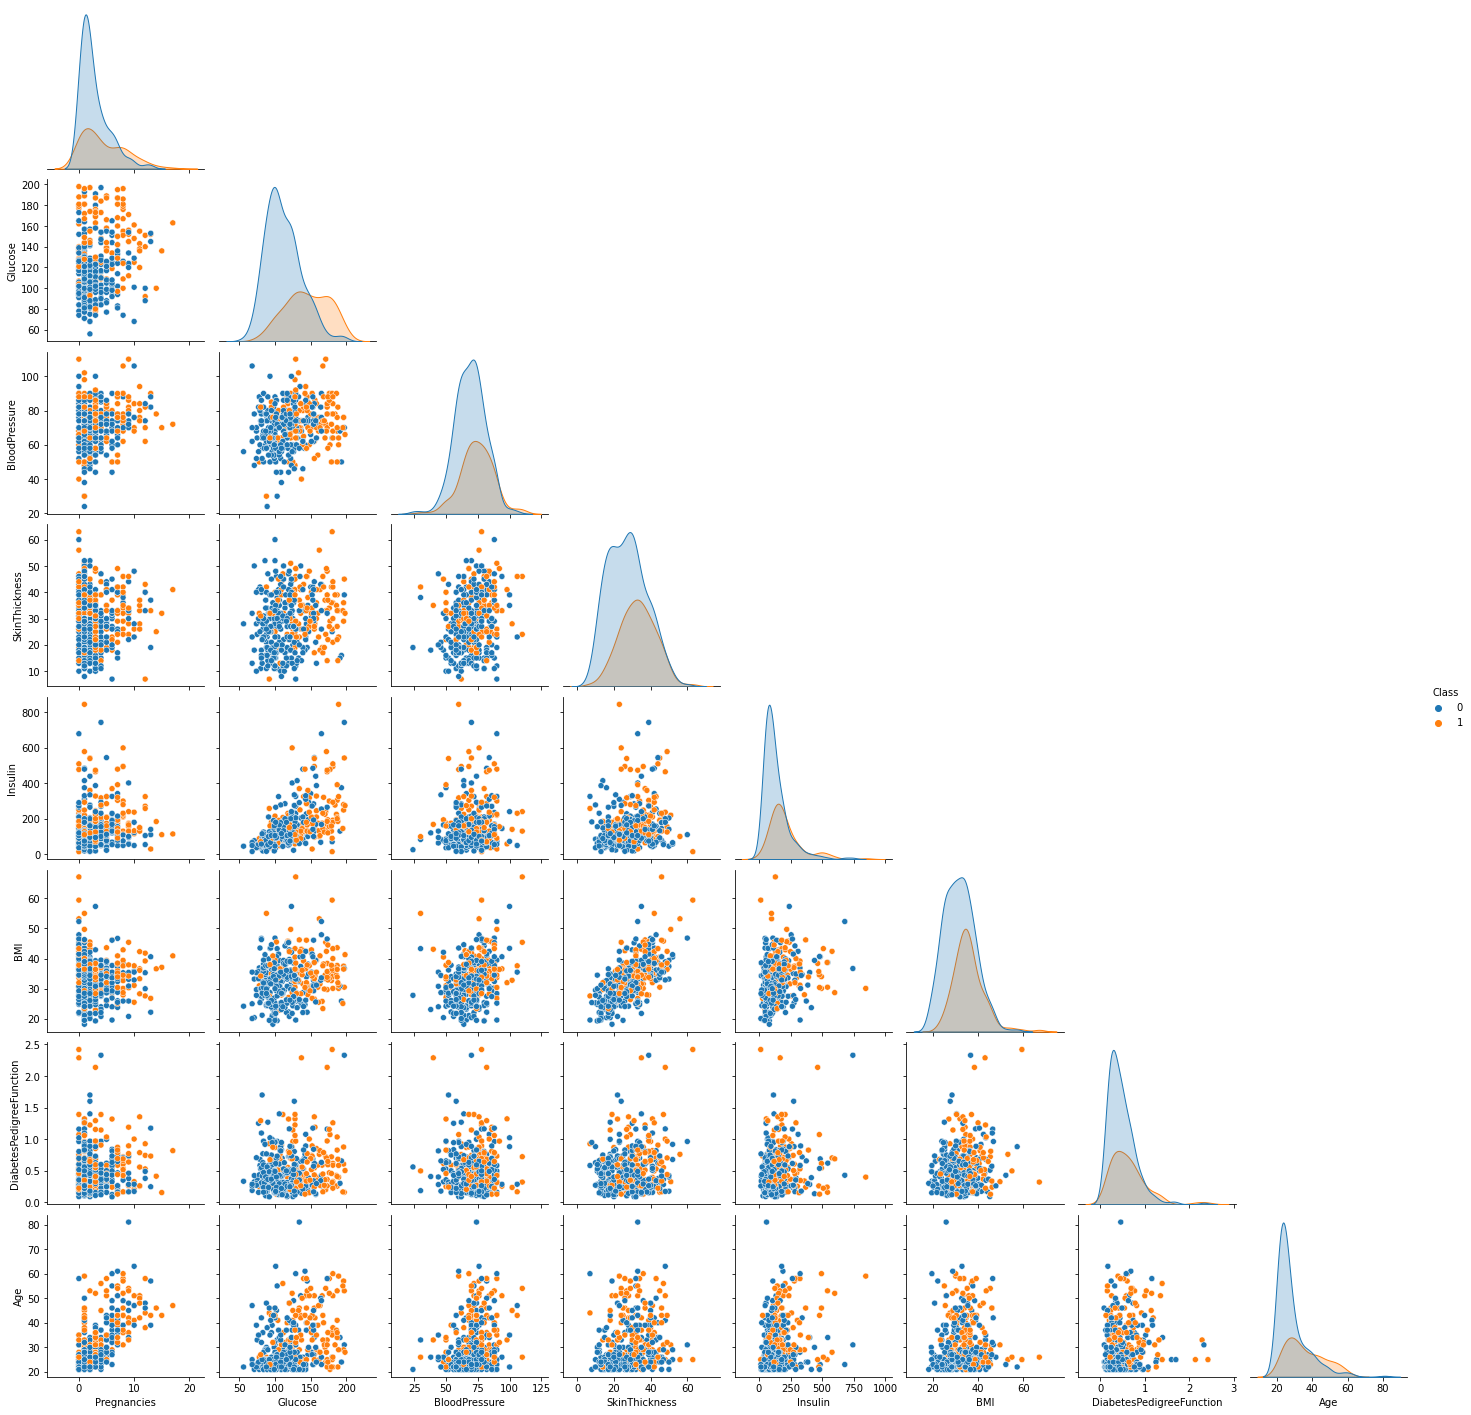

In [19]:
a = sns.pairplot(data=exp_df, hue='Class', corner=True)

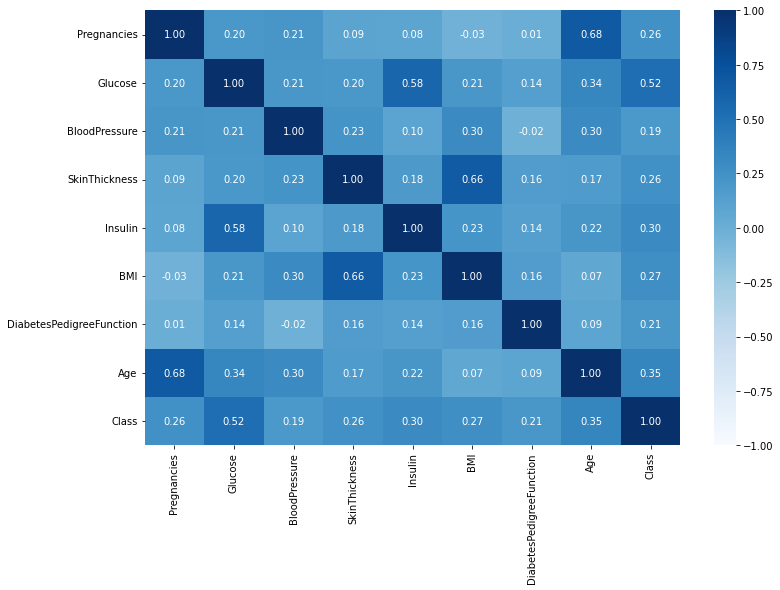

In [20]:
f, ax = plt.subplots(figsize=(12, 8))
a = sns.heatmap(data=exp_df.corr(), annot=True, fmt=".2f", cmap='Blues', vmin=-1.0, vmax=1.0, center=0.0)

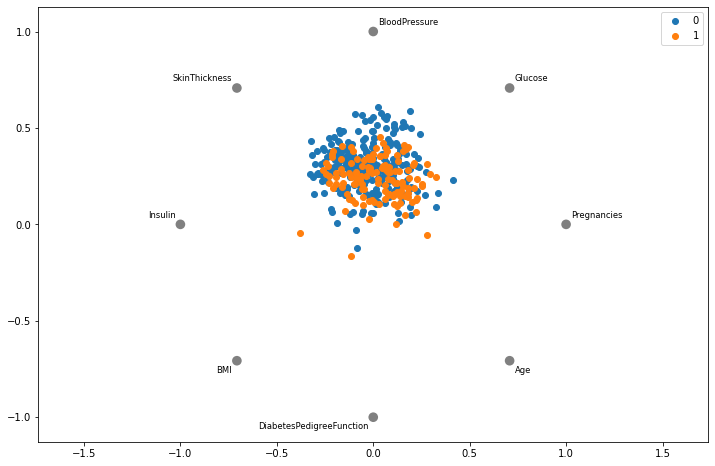

In [21]:
f, ax = plt.subplots(figsize=(12, 8))
a = pd.plotting.radviz(frame=exp_df, class_column='Class', color=sns.color_palette())

Пока можно сказать, что инсулин, количестыво беременностей, наследственность, глюкоза и возраст ощутимо влияют на наличие диабета.

In [22]:
exp_model_dt = train_decision_tree('exp_model_dt', X_train_e, y_train_e)

x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [23]:
exp_model_dt_pred_test = exp_model_dt.predict_proba(X_test_e)
exp_model_dt_pred_train = exp_model_dt.predict_proba(X_train_e)

print("AUC for test data {:.4f}.".format(roc_auc_score(y_test_e, exp_model_dt_pred_test[:, 1])))
print("AUC for train data {:.4f}.".format(roc_auc_score(y_train_e, exp_model_dt_pred_train[:, 1])))

AUC for test data 0.8095.
AUC for train data 0.7385.


Переобучения, похоже, нет.

In [25]:
exp_perm = PermutationImportance(exp_model_dt, random_state=42, scoring='roc_auc', n_iter=100).fit(X_test_e, y_test_e)
eli5.explain_weights(exp_perm, feature_names=X_e.columns.values)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'min_impurity_split'

Вот это номер... Получается, что модель предсказывает диабет по глюкозе?

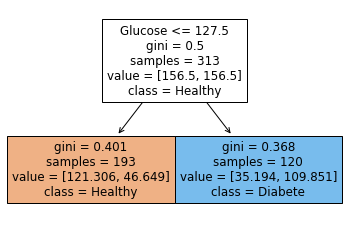

In [26]:
a = plot_tree(exp_model_dt, feature_names = X_e.columns, class_names=['Healthy', 'Diabete'], filled=True)

Так и есть. В жизни, в принципе, это тоже основной показатель.

Но точность так себе. 

**Ансамбль - Random Forest.**

In [27]:
model_rf = train_random_forest('model_rf', X_train_e, y_train_e.to_numpy().flatten())

x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [28]:
model_rf_pred_train = model_rf.predict_proba(X_train_e)
model_rf_pred_test = model_rf.predict_proba(X_test_e)

print("AUC for test data {:.4f}.".format(roc_auc_score(y_test_e, model_rf_pred_test[:, 1])))
print("AUC for train data {:.4f}.".format(roc_auc_score(y_train_e, model_rf_pred_train[:, 1])))

AUC for test data 0.9006.
AUC for train data 0.8643.


Вот этот результат мне больше нравится.

In [29]:
rf_perm = PermutationImportance(model_rf, random_state=42, scoring='roc_auc', n_iter=100).fit(X_test_e, y_test_e)
eli5.show_weights(rf_perm, feature_names=X_e.columns.values)

AttributeError: 'RandomForestClassifier' object has no attribute 'min_impurity_split'

Для случайного леса важна не только глюкоза, но она по прежнему самый значимый предиктор. 

**Импутация данных.**

Я буду использовать KNNImputer.

Для начала, посмотрю какую точность он дает на экспериментальном датасете.

В экспериментальном датасете заменю случайно выбранные значения в той-же пропорции, что и в полном.

In [30]:
knn_test_insulin_idx = np.random.choice(a=exp_df.index, size=(int(exp_df.shape[0] * 0.49)))
knn_test_skin_idx = np.random.choice(a=exp_df.index, size=(int(exp_df.shape[0] * 0.29)))
knn_test_blodp_idx = np.random.choice(a=exp_df.index, size=(int(exp_df.shape[0] * 0.05)))
knn_test_bmi_idx = np.random.choice(a=exp_df.index, size=(int(exp_df.shape[0] * 0.015)))

In [31]:
knn_test_df = exp_df.drop('Class', axis=1).copy()

In [32]:
knn_test_df.loc[knn_test_insulin_idx, ['Insulin']] = np.NaN
knn_test_df.loc[knn_test_skin_idx, ['SkinThickness']] = np.NaN
knn_test_df.loc[knn_test_blodp_idx, ['BloodPressure']] = np.NaN
knn_test_df.loc[knn_test_bmi_idx, ['BMI']] = np.NaN

In [33]:
knn_test_df.isna().sum()

Pregnancies                   0
Glucose                       0
BloodPressure                19
SkinThickness                95
Insulin                     153
BMI                           5
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [34]:
test_knn_imputer = KNNImputer(n_neighbors=7, weights='distance')
test_knn_predicted = test_knn_imputer.fit_transform(knn_test_df)

In [35]:
print("R2 score for imputed data is {:.4f}.".format(r2_score(exp_df.drop('Class', axis=1).to_numpy().flatten(), test_knn_predicted.flatten())))

R2 score for imputed data is 0.9253.


Вполне неплохо.

Посмотрю как модель предсазывает на импутированных данных.

In [36]:
X_e_i = pd.DataFrame(data=test_knn_predicted, columns=X_e.columns)
y_e = exp_df[['Class']]

X_train_e_i, X_test_e_i, y_train_e_i, y_test_e_i = train_test_split(X_e_i, y_e, test_size=0.2, shuffle=True, random_state=42, stratify=y_e)

model_rf_imp_pred_train = model_rf.predict_proba(X_train_e_i)
model_rf_imp_pred_test = model_rf.predict_proba(X_test_e_i)

print("AUC for test data {:.4f}.".format(roc_auc_score(y_test_e_i, model_rf_imp_pred_test[:, 1])))
print("AUC for train data {:.4f}.".format(roc_auc_score(y_train_e_i, model_rf_imp_pred_train[:, 1])))

AUC for test data 0.8940.
AUC for train data 0.8623.


In [37]:
rf_perm_i = PermutationImportance(model_rf, random_state=42, scoring='roc_auc', n_iter=100).fit(X_test_e_i, y_test_e_i)
eli5.show_weights(rf_perm_i, feature_names=X_e.columns.values)

AttributeError: 'RandomForestClassifier' object has no attribute 'min_impurity_split'

Почти то же самое.

## **Конструирование признаков.**

Мне интересно разделить значения на теже категории, что и в оригинальном исследовании. И сравнить полученные результаты. 

In [38]:
test_knn_predicted = pd.DataFrame(data=test_knn_predicted, columns=src_df.drop('Class', axis=1).columns)

test_knn_predicted_c = construct_df(test_knn_predicted, test_knn_predicted.columns)

In [39]:
exp_df_c = construct_df(exp_df, src_df.drop('Class', axis=1).columns)

In [40]:
print("R2 score for constructed imputed data is {:.4f}.".format(r2_score(exp_df_c.to_numpy().flatten(), test_knn_predicted_c.to_numpy().flatten())))

R2 score for constructed imputed data is 0.9533.


Неплохо точность выросла. Но это я обрабатывал уже предсказанное. А если по новому импутировать?

In [41]:
test_knn_imputer = KNNImputer(n_neighbors=10, weights='uniform')
test_knn_predicted = test_knn_imputer.fit_transform(construct_df(knn_test_df, src_df.drop('Class', axis=1).columns))

In [42]:
print("R2 score for constructed imputed data is {:.4f}.".format(r2_score(exp_df_c.to_numpy().flatten(), test_knn_predicted.flatten())))

R2 score for constructed imputed data is 0.9636.


Немного лучше!

А теперь попробую на новых данных потренировать модель.

In [43]:
X_e_с = exp_df_c

X_train_e_с, X_test_e_с, y_train_e_с, y_test_e_с = train_test_split(X_e_с, y_e, test_size=0.2, shuffle=True, random_state=42, stratify=y_e)

In [44]:
model_rf_с = train_random_forest('model_rf_с', X_train_e_с, y_train_e_с.to_numpy().flatten())

x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [45]:
model_rf_с_pred_train = model_rf_с.predict_proba(X_train_e_с)
model_rf_с_pred_test = model_rf_с.predict_proba(X_test_e_с)

print("AUC for test data {:.4f}.".format(roc_auc_score(y_test_e_с, model_rf_с_pred_test[:, 1])))
print("AUC for train data {:.4f}.".format(roc_auc_score(y_train_e, model_rf_с_pred_train[:, 1])))

AUC for test data 0.8908.
AUC for train data 0.8539.


На сконструированных данных точность немного упала. 

## **Рабочая модель.**

In [94]:
work_df = construct_df(src_df.drop('Class', axis=1), src_df.drop('Class', axis=1).columns)

In [95]:
work_df_imputed = test_knn_imputer.fit_transform(work_df)

In [100]:
work_df = pd.DataFrame(data=work_df_imputed, columns=work_df.columns)

work_df = construct_df(pd.DataFrame(data=work_df_imputed, columns=work_df.columns), work_df.columns)

In [101]:
work_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [102]:
work_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Glucose,768.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
BloodPressure,768.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
SkinThickness,768.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Insulin,768.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
BMI,768.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
DiabetesPedigreeFunction,768.0,2.583333,1.563379,0.0,0.0,3.0,4.0,4.0
Age,768.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0


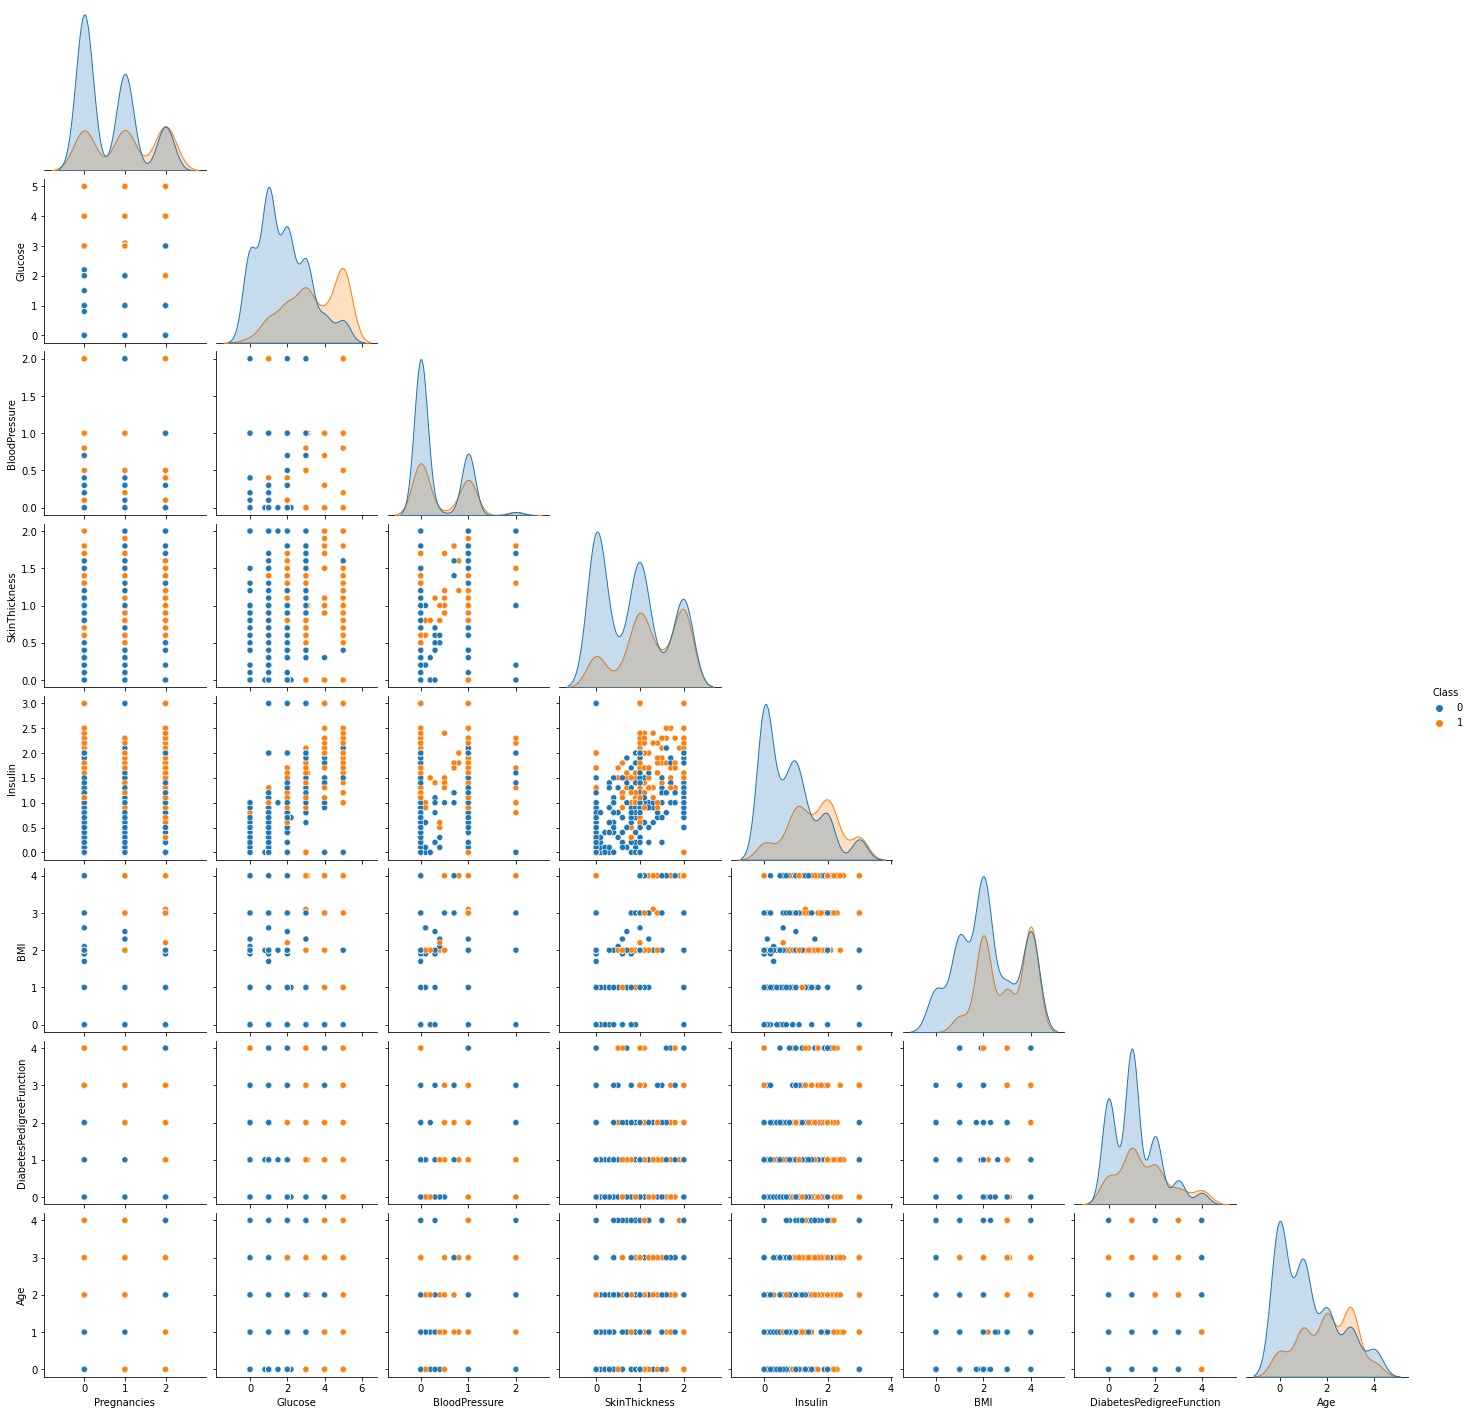

In [99]:
a = sns.pairplot(data=work_df.join(src_df[['Class']]), hue='Class', corner=True)

Как по мне, график стал несколько более наглядным.

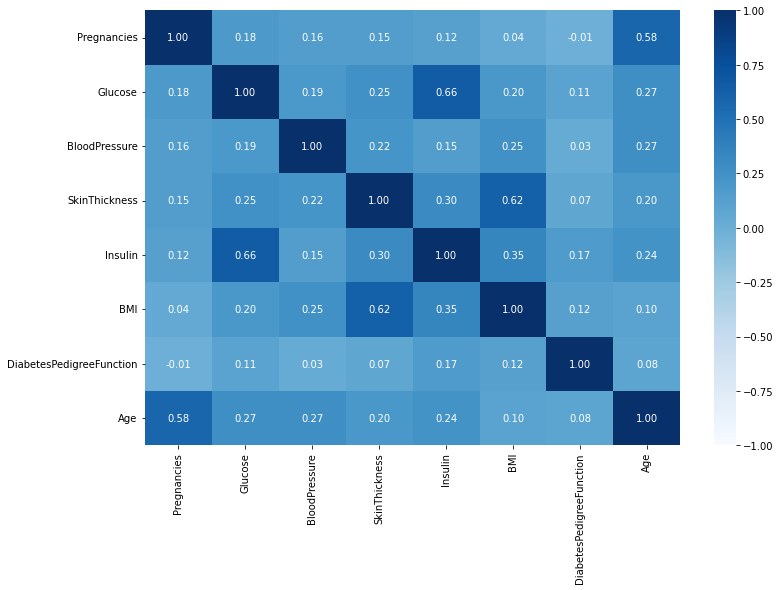

In [52]:
f, ax = plt.subplots(figsize=(12, 8))
a = sns.heatmap(data=work_df.corr(), annot=True, fmt=".2f", cmap='Blues', vmin=-1.0, vmax=1.0, center=0.0)

In [53]:
X_ = work_df.copy()
y_ = src_df[['Class']].to_numpy().flatten()

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, shuffle=True, random_state=42, stratify=y_)

**Naive Bayes**

In [55]:
model_naive_bayes = GaussianNB()

if isfile("./data/models/model_naive_bayes.pkl"):
    with open("./data/models/model_naive_bayes.pkl", "rb") as m_file:
        model_naive_bayes = pickle.load(m_file)
else:
    model_nb_best = GaussianNB()
    
    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    best_score = 0
    
    for train_index, test_index in cross_val.split(X_, y_):
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_[train_index], y_[test_index]
        
        model_naive_bayes.fit(X_train, y_train)
        model_naive_bayes_pred = model_naive_bayes.predict(X_test)
        
        score = roc_auc_score(y_test, model_naive_bayes_pred)
        
        if score > best_score:
            best_score = score
            model_nb_best = model_naive_bayes
    
    model_naive_bayes = model_nb_best
    with open("./data/models/model_naive_bayes.pkl", "wb") as m_file:
        pickle.dump(model_nb_best, m_file)

x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator GaussianNB from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [56]:
model_naive_bayes_pred_test = model_naive_bayes.predict_proba(X_test)
model_naive_bayes_pred_train = model_naive_bayes.predict_proba(X_train)

print("GaussianNB AUC for test data {:.4f}.".format(roc_auc_score(y_test, model_naive_bayes_pred_test[:, 1])))
print("GaussianNB AUC for train data {:.4f}.".format(roc_auc_score(y_train, model_naive_bayes_pred_train[:, 1])))

AttributeError: 'GaussianNB' object has no attribute 'sigma_'

**Logistic Regression**

In [57]:
model_logistic_regression = LogisticRegression()

if isfile("./data/models/model_logistic_regression.pkl"):
    with open("./data/models/model_logistic_regression.pkl", "rb") as m_file:
        model_logistic_regression = pickle.load(m_file)
else:
    model_lr = LogisticRegression()
    
    c_values = np.arange(1, 100, 1)
    l1_ratio = np.arange(0.1, 0.9, 0.1)
    
    
    params = [
        {'solver': ['sag'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['sag'], 'penalty': ['none']},
        {'solver': ['newton-cg'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['newton-cg'], 'penalty': ['none']},
        {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': c_values},
        {'solver': ['lbfgs'], 'penalty': ['none']},
        {'solver': ['saga'], 'penalty': ['l2', 'l1'], 'C': c_values},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': c_values, 'l1_ratio': l1_ratio},
        {'solver': ['saga'], 'penalty': ['none']}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    grid_search = GridSearchCV(estimator=model_lr, param_grid=params, cv=cross_val, scoring='roc_auc', error_score='raise')
    
    with ignore_warnings(category=ConvergenceWarning):
        lr_result = grid_search.fit(X_train, y_train)
    
    model_logistic_regression = lr_result.best_estimator_
    
    with open("./data/models/model_logistic_regression.pkl", "wb") as m_file:
        pickle.dump(lr_result, m_file)

x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
x:\profiles\user_\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [58]:
model_logistic_regression_pred_test = model_logistic_regression.predict_proba(X_test)
model_logistic_regression_pred_train = model_logistic_regression.predict_proba(X_train)

print("Loistic Regression AUC for test data {:.4f}.".format(roc_auc_score(y_test, model_logistic_regression_pred_test[:, 1])))
print("Loistic Regression AUC for train data {:.4f}.".format(roc_auc_score(y_train, model_logistic_regression_pred_train[:, 1])))

Loistic Regression AUC for test data 0.8231.
Loistic Regression AUC for train data 0.8546.


**Decision Tree**

In [77]:
model_decision_tree = train_decision_tree('model_decision_tree', X_train, pd.DataFrame(data=y_train, columns=['Class']))

Fitting 30 folds for each of 24192 candidates, totalling 725760 fits
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto', 'max_leaf_nodes': 2, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
Training took 1084.86s.


In [84]:
decision_tree_pred_test = model_decision_tree.predict_proba(X_test)
decision_tree_pred_train = model_decision_tree.predict_proba(X_train)

print("Decision Tree AUC for test data {:.4f}.".format(roc_auc_score(y_test, decision_tree_pred_test[:, 1])))
print("Decision Tree AUC for train data {:.4f}.".format(roc_auc_score(y_train, decision_tree_pred_train[:, 1])))

Decision Tree AUC for test data 0.6596.
Decision Tree AUC for train data 0.7108.


**Random Forest**

In [82]:
model_random_forest = train_random_forest('model_random_forest', X_train, y_train)

In [83]:
random_forest_pred_test = model_random_forest.predict_proba(X_test)
random_forest_pred_train = model_random_forest.predict_proba(X_train)

print("Random Forest AUC for test data {:.4f}.".format(roc_auc_score(y_test, random_forest_pred_test[:, 1])))
print("Random Forest AUC for train data {:.4f}.".format(roc_auc_score(y_train, random_forest_pred_train[:, 1])))

Random Forest AUC for test data 0.8086.
Random Forest AUC for train data 0.8591.


**SVC**

In [89]:
model_svc = SVC(probability=True)

if isfile("./data/models/model_svc.pkl"):
    with open("./data/models/model_svc.pkl", "rb") as m_file:
        model_svc = pickle.load(m_file)
else:
    c_values = np.arange(1, 100, 1)
    gamma_p = ['scale', 'auto']
    degree_p = np.arange(1, 10, 1)
    coef0_p = np.arange(0, 1, 0.1)
    
    params = [
        {'kernel': ['linear'], 'C': c_values},
        #{'kernel': ['poly'], 'C': c_values, 'degree': degree_p, 'gamma': gamma_p, 'coef0': coef0_p},
        {'kernel': ['rbf'], 'C': c_values, 'gamma': gamma_p},
        #{'kernel': ['sigmoid'], 'C': c_values, 'gamma': gamma_p, 'coef0': coef0_p}
    ]

    cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    grid_search = GridSearchCV(estimator=model_svc, param_grid=params, n_jobs=-1, cv=cross_val, scoring='roc_auc', error_score='raise', verbose=1)
    svc_result = grid_search.fit(X_train, y_train)
    
    model_svc = svc_result.best_estimator_
    
    with open("./data/models/model_svc.pkl", "wb") as m_file:
        pickle.dump(model_svc, m_file)

In [90]:
svc_pred_test = model_svc.predict_proba(X_test)
svc_pred_train = model_svc.predict_proba(X_train)

print("SVC AUC for test data {:.4f}.".format(roc_auc_score(y_test, svc_pred_test[:, 1])))
print("SVC AUC for train data {:.4f}.".format(roc_auc_score(y_train, svc_pred_train[:, 1])))

SVC AUC for test data 0.8289.
SVC AUC for train data 0.8531.
